In [1]:
import numpy as np
import random
import math
import time
import os
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 1. load data

In [2]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 1.1 Extract raw data

In [4]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('datasets/CALCE/CALCE.npy', allow_pickle=True)
Battery = Battery.item()

## 1.2 plot figures for capacity degradation

In [11]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()


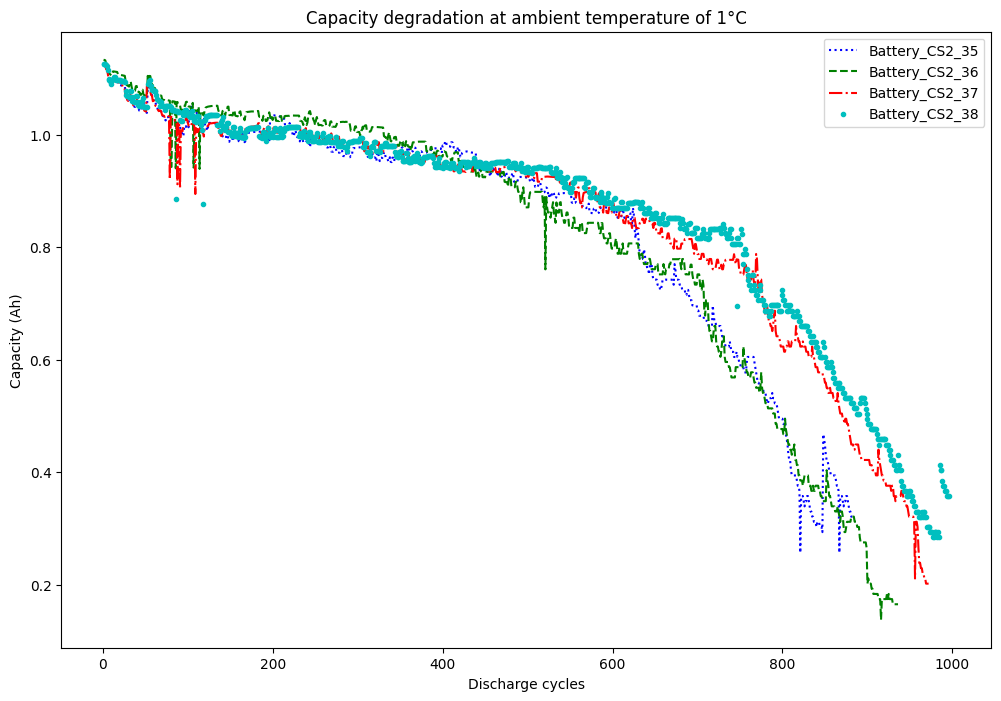

In [12]:
plt.show()